In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

In [2]:
ROOT_PATH = Path("..")

In [3]:
df =  pd.read_csv("Fornax.csv")
df[:7]

,ID,RA,DEC,CLASS_STAR,ELLIPTICITY,ELONGATION,FLUX_RADIUS,FWHM,ISOarea,KRON_RADIUS,...,r_aper_6,r_petro,J0660_auto,e_J0660_auto,i_auto,e_i_auto,J0861_auto,e_J0861_auto,z_auto,e_z_auto
0,iDR3.SPLUS-s25s32.020036,49.494328,-32.350563,0.459624,0.449875,1.817768,"[1.242211,2.5662715,5.71492,6.890029]",6.085031,4,7.132851,...,22.020140,22.050888,21.547064,0.332771,20.859621,0.228180,21.274414,0.722951,21.610172,0.819430
1,iDR3.SPLUS-s25s32.020080,50.198927,-32.346923,0.109929,0.570968,2.330827,"[,2.5440927,6.0819097,13.687574,16.590715]",10.850546,6,6.866231,...,21.406225,21.159723,21.103397,0.364895,21.307234,0.578285,19.840270,0.325530,19.682186,0.234320
2,iDR3.SPLUS-s25s32.000003,48.584174,-32.943812,0.354856,0.540795,2.177678,"[1.6309174,6.080961,8.323008,8.323008]",5.599145,3,8.338106,...,21.733967,22.002377,22.599194,0.931227,21.177631,0.337640,23.768717,7.871729,20.785189,0.421435
3,iDR3.SPLUS-s25s32.020094,49.989457,-32.347656,0.359414,0.614246,2.592326,"[1.7771757,4.343724,5.75436,8.281901]",0.000000,1,7.876084,...,22.345322,22.107891,20.608524,0.196191,20.660837,0.268005,20.264135,0.403934,20.136244,0.298935
4,iDR3.SPLUS-s25s32.020131,49.084647,-32.347389,0.001687,0.147096,1.172465,"[1.2690732,2.1671884,2.9067676,4.002029]",10.163368,16,6.591668,...,20.751575,20.507515,20.539282,0.200926,21.079853,0.427792,21.307450,1.145674,20.711657,0.551694
5,iDR3.SPLUS-s25s32.020154,49.120796,-32.346761,0.352127,0.570009,2.325628,"[2.2475142,4.255869,5.7240915,9.093431]",0.000000,0,9.242299,...,21.277360,21.066496,21.307652,0.332644,20.876568,0.290862,20.781640,0.578610,21.313140,0.785182
6,iDR3.SPLUS-s25s32.020167,48.998876,-32.346299,0.079948,0.368976,1.584726,"[1.0609581,1.928098,2.6100047,3.696454]",5.915680,8,6.762239,...,21.842730,21.736881,21.575140,0.382382,22.203756,0.887705,20.599016,0.441643,20.181122,0.250489


In [4]:
# drop 99 value on the r-band
df = df.mask(df["r_auto"] == 99.) 


In [5]:
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
RA,118350.0,52.375484,2.778122,47.555626,50.066332,51.567279,54.607582,59.197326
DEC,118350.0,-34.466654,1.626036,-38.221105,-35.620268,-33.967975,-33.280872,-31.514553
CLASS_STAR,118350.0,0.288229,0.232930,0.000024,0.052841,0.347576,0.431019,0.999889
ELLIPTICITY,118350.0,0.303778,0.173307,0.000090,0.169013,0.289333,0.416806,0.890988
ELONGATION,118350.0,1.557842,0.536062,1.000090,1.203388,1.407130,1.714696,9.173266
FWHM,118350.0,4.649383,3.509200,-22.312414,2.175852,4.797357,6.775927,346.055760
ISOarea,118350.0,12.567047,196.994386,0.000000,1.000000,3.000000,8.000000,42197.000000
KRON_RADIUS,118350.0,6.946760,1.935139,0.000000,6.538283,7.211893,8.126989,12.307342
MU_MAX,118350.0,17.874964,0.962862,9.069814,17.765944,18.115874,18.335602,19.720228
A,118350.0,1.448245,0.682410,0.496715,1.062465,1.362493,1.709479,82.813835


In [6]:
# Select colums
cols = ["KRON_RADIUS", "MU_MAX", "r_auto"]
df_new = df[cols]
df_new.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
KRON_RADIUS,118350.0,6.946760,1.935139,0.000000,6.538283,7.211893,8.126989,12.307342
MU_MAX,118350.0,17.874964,0.962862,9.069814,17.765944,18.115874,18.335602,19.720228
r_auto,118350.0,21.463251,1.297202,7.873619,20.858799,21.478884,22.108029,34.613815


In [7]:
# Cheking if these columns have infinite values
ds = df_new.isin([np.inf, -np.inf])
print(ds)

        KRON_RADIUS  MU_MAX  r_auto
0             False   False   False
1             False   False   False
2             False   False   False
3             False   False   False
4             False   False   False
...             ...     ...     ...
122190        False   False   False
122191        False   False   False
122192        False   False   False
122193        False   False   False
122194        False   False   False

[122195 rows x 3 columns]


In [8]:
count = np.isinf(df_new).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 0 infinite values


In [9]:
# counting infinity in a particular column name
c = np.isinf(df_new['MU_MAX']).values.sum()
print("It contains " + str(c) + " infinite values")

It contains 0 infinite values


In [10]:
# checking NaN value
count1 = np.isnan(df_new).values.sum()
print("It contains " + str(count1) + " nan values")

It contains 11535 nan values


In [22]:
c1 = np.isnan(df_new['MU_MAX']).values.sum()
print("It contains " + str(c1) + " nan values")

It contains 3845 nan values


In [26]:
# removing the nan values
#xx = np.nan_to_num(df_new)
xx = df_new.dropna()
len(xx)

118350

In [27]:
print("Shape:", xx.shape)

Shape: (118350, 3)


We need to rescale the data. The variables used here have different units.

In [30]:
X = StandardScaler().fit_transform(xx)

# Using HDBSCAN

In [137]:
clusterer = hdbscan.HDBSCAN(min_samples=18, min_cluster_size=80, prediction_data=True).fit(X)
labels = clusterer.labels_

In [138]:
# checking metric
clusterer.metric

'euclidean'

In [158]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster6 = list(labels).count(6)
n_noise_ = list(labels).count(-1)


In [159]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 6: %d' % n_cluster6)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of cluster points 0: 132
Estimated number of cluster points 1: 186
Estimated number of cluster points 2: 93
Estimated number of cluster points 6: 80022
Estimated number of noise points: 32245


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MU_MAX', ylabel='KRON_RADIUS'>

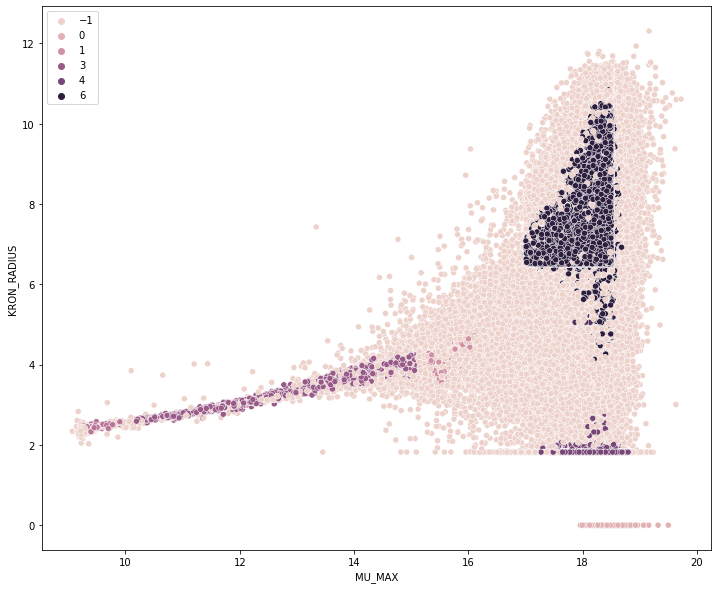

In [160]:
plt.figure(figsize=(12,10))
sns.scatterplot(xx["MU_MAX"], xx["KRON_RADIUS"], 
                hue=labels
                )

In [161]:
xx["Label"] = labels

Plotting only the objects of the triangle

[(9.0, 21.0), (-0.5, 11.0)]

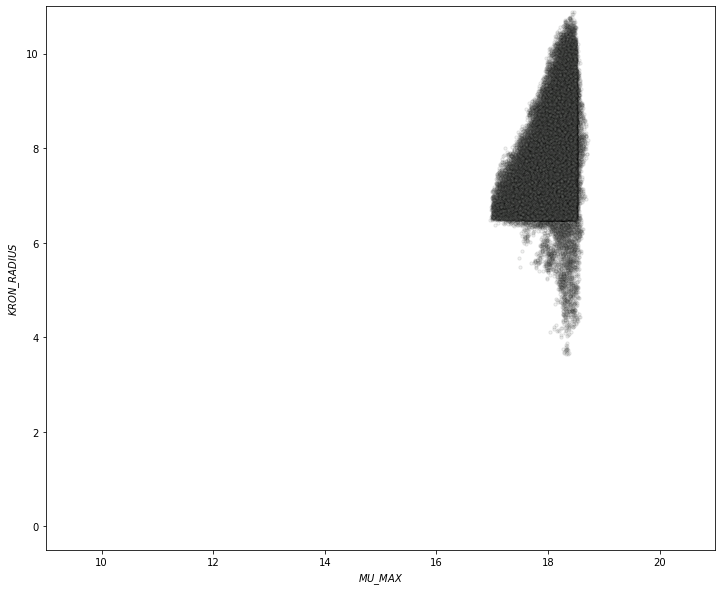

In [162]:
fig, ax = plt.subplots(figsize=(12, 10))

m = xx["Label"] == 6
ax.scatter(xx["MU_MAX"][m], xx["KRON_RADIUS"][m],
            c=sns.xkcd_rgb['grey'], s=10, edgecolor='black', alpha=0.1,
            cmap=plt.cm.get_cmap('Accent', 10))
ax.set_xlabel(r'$MU\_MAX$')
ax.set_ylabel(r'$KRON\_RADIUS$')
ax.set(xlim=[9, 21], ylim=[-0.5, 11])

In [164]:
print("Number of sources on this cluster:", xx["MU_MAX"][m])

Number of sources on this cluster: 0         18.229320
2         17.924402
3         18.066620
4         17.857449
5         18.459253
            ...    
122189    18.471706
122190    18.353104
122191    18.434996
122193    18.395640
122194    18.135204
Name: MU_MAX, Length: 80022, dtype: float64
